In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import pandas as pd
from skimage import data, io, filters

import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from helpers_functions import *
from features_extraction import *
from features_increase import *

# Loading train

In [2]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files = list(np.sort(files))
n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images of the training set")

imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images of ground truth");
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

n=100; # number of images considered


Loading 100 images of the training set
Loading 100 images of ground truth


In [3]:
# generate the lables

# choose the patch size

patch_size=4;



gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

# Extracting the features

In [10]:
#TRAINING SET 

# selected the number of features of the PATCH interested  
# max value: 24 

# - add_RGB_features : mean(R) , mean(G) , mean(B) , var(R) , var(G) , var(B)
# - add_grey_features : mean_of_the_patch, var_of_the_patch
# - add_RGB_spectrum_features: being F Fourier transofrm of the single 
#   patch in RGB. F is a matrix of patch_size x patch_size x 3, where the three componen
#   is caused by the fact that we consider R,G,B image.
#   These are in total 12 features:  mean(abs(F[:,:,0])) , mean(abs(F[:,:,1])) ...
#                                    mean(arg(F[:,:,0])) , mean(arg(F[:,:,1])), ..
#                                    var(abs(F[:,:,0]))) , var(abs(F[:,:,1])) ...
#                                    var(arg(F[:,:,0]))  , var(arg(F[:,:,1])), ..
# - add_grey_spectrum_features:  being F_grey the  Fourier transofrm of the single 
#   patch in greyscale we consider:  mean(abs(F_grey))
#                                    mean(arg(F_grey)) 
#                                    var(abs(F_grey)) 
#                                    var(arg(F_grey))
#                                    
                            
# n_features has to be the sum of the number of the features selected


n_features=8; # number of features interested () 
add_RGB_features=1; # 6 features
add_grey_features=1; # 2 features 
add_RGB_spectrum_features=0; #12 features
add_grey_spectrum_features=0; # 4 features 


#ATTENTION the sum of the number of the features selected have to equal to the number of the features

In [11]:
# Extract patches from input images (train) 
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
#extracting the features
X_train=extract_new_features(img_patches,n_features,add_RGB_features,add_grey_features,add_RGB_spectrum_features,add_grey_spectrum_features)


# Loading test

In [10]:
# Extract patches from input images (test)
import glob

root_dir = "test_set_images/";

files_1  = os.listdir(root_dir)
imgs_test=[];
for i in range(len(files_1)):
    
    ind=i+1;
    image_dir="test_"+str(ind)+"/";
    path=root_dir+image_dir
    files = os.listdir(path)
    img = load_image(path + files[0])
    imgs_test.append(img)
    print(path+files[0])
    



test_set_images/test_1/test_1.png
test_set_images/test_2/test_2.png
test_set_images/test_3/test_3.png
test_set_images/test_4/test_4.png
test_set_images/test_5/test_5.png
test_set_images/test_6/test_6.png
test_set_images/test_7/test_7.png
test_set_images/test_8/test_8.png
test_set_images/test_9/test_9.png
test_set_images/test_10/test_10.png
test_set_images/test_11/test_11.png
test_set_images/test_12/test_12.png
test_set_images/test_13/test_13.png
test_set_images/test_14/test_14.png
test_set_images/test_15/test_15.png
test_set_images/test_16/test_16.png
test_set_images/test_17/test_17.png
test_set_images/test_18/test_18.png
test_set_images/test_19/test_19.png
test_set_images/test_20/test_20.png
test_set_images/test_21/test_21.png
test_set_images/test_22/test_22.png
test_set_images/test_23/test_23.png
test_set_images/test_24/test_24.png
test_set_images/test_25/test_25.png
test_set_images/test_26/test_26.png
test_set_images/test_27/test_27.png
test_set_images/test_28/test_28.png
test_set_i

In [11]:
# extract features for test 
img_patches = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(len(imgs_test))]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])

X_test=extract_new_features(img_patches,n_features,add_RGB_features,add_grey_features,add_RGB_spectrum_features,add_grey_spectrum_features)



# KNN

# CROSS VALIDATION ON KNN

In [14]:

def build_k_indices(y, k_fold, seed):
    """Build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_one_fold_KNN(y_cross_val_train, y_cross_val_test, tx_cross_val_train, tx_cross_val_test, \
                                 degrees, n_neighbors, max_iters):
    
    accuracies_train_by_deg = np.zeros([len(degrees),len(n_neighbors)])
    accuracies_test_by_deg = np.zeros([len(degrees),len(n_neighbors)])
    
    # For each degree, compute the least squares weights, the predictions and the accuracies
    
    for deg_id, deg in enumerate(degrees):
        print('++ Degree', deg, '++')
                
        # Add powers of the chosen columns
        len_data = tx_cross_val_train.shape[1]
        if(deg>1):
            tx_cross_val_train = add_powers(tx_cross_val_train,deg )
            tx_cross_val_test = add_powers(tx_cross_val_test,deg )
        
        tx_cross_val_train = add_ones(tx_cross_val_train )
        tx_cross_val_test = add_ones(tx_cross_val_test)
        for single_n_neighbors_id in range(0,len(n_neighbors)):
                single_n_neighbors=n_neighbors[single_n_neighbors_id]
                print('>> n_neighbors',single_n_neighbors, '<<')
                # Compute the best weights on the training set
                neigh = KNeighborsClassifier(n_neighbors=single_n_neighbors)
                neigh.fit(tx_cross_val_train, y_cross_val_train) 

                # Compute the predictions
                y_predicted_cross_val_train = neigh.predict(tx_cross_val_train)
                y_predicted_cross_val_test = neigh.predict(tx_cross_val_test)



                # Compute the accuracies for each degree
                accuracies_train_by_deg[deg_id,single_n_neighbors_id] = \
                    np.sum(y_predicted_cross_val_train == y_cross_val_train)/len(y_cross_val_train)
                accuracies_test_by_deg[deg_id,single_n_neighbors_id] = \
                    np.sum(y_predicted_cross_val_test == y_cross_val_test)/len(y_cross_val_test)


                print(accuracies_test_by_deg[deg_id,single_n_neighbors_id])
        
        # Update the previous degree to the actual degree
        
        
    return accuracies_train_by_deg, accuracies_test_by_deg






def cross_validation_KNN(Y,X, degrees,n_neighborss,k_fold, seed, max_iters):
    
    # Get the indices so that we get the k'th subgroup in test, others in train, for each k
    k_indices = build_k_indices(Y, k_fold, seed)
    
    # Initialize matrix of computed accuracies for each degree and each fold

  
    accuracies_train_by_fold = np.zeros([len(degrees), len(n_neighbors), k_fold])
    accuracies_test_by_fold = np.zeros([len(degrees), len(n_neighbors), k_fold])
        
    for k in range(k_fold):
            print('--- Fold', k, '---')
            # Create the testing set for this fold number
            k_index = k_indices[k] # Indices of the testing set for fold k
            Y_cross_val_test = Y[k_index]
            X_cross_val_test = X[k_index,:]


            # Create the training set for this fold number
            mask = np.ones(len(Y), dtype=bool) # set all elements to True
            mask[k_index] = False # set test elements to False
            Y_cross_val_train = Y[mask] # select only True elements (ie train elements)
            X_cross_val_train = X[mask,:]

            # Compute the accuracies for each degree
            accuracies_train_by_fold[:,:,k], accuracies_test_by_fold[:,:,k] = cross_validation_one_fold_KNN\
                (Y_cross_val_train, Y_cross_val_test, X_cross_val_train, X_cross_val_test, \
                                     degrees, n_neighbors,max_iters)
            print(accuracies_test_by_fold[:,:,k])
        
        
    # Compute the mean accuracies over the folds, for each degree
    mean_accuracies_train_by_deg = np.mean(accuracies_train_by_fold, axis=2)
    mean_accuracies_test_by_deg = np.mean(accuracies_test_by_fold, axis=2)
       

    # Get the index of the best accuracy in the testing set
    max_id_deg_test,max_id_n_neighbors = \
            np.unravel_index(mean_accuracies_test_by_deg.argmax(), mean_accuracies_test_by_deg.shape)

    # Find the optimal degree and the corresponding accuracies in the training and testing sets
    best_deg = degrees[max_id_deg_test]
    best_n_neighbors=n_neighbors[max_id_n_neighbors]
    best_accuracy_test = mean_accuracies_test_by_deg[max_id_deg_test,max_id_n_neighbors]
    corresponding_accuracy_train = mean_accuracies_train_by_deg[max_id_deg_test,max_id_n_neighbors]
        
    
    print('Best accuracy test =', best_accuracy_test, 'with degree =', best_deg , 'n_neighbors=',best_n_neighbors)
    print('Corresponding accuracy train =', corresponding_accuracy_train)
      
        
   
 
        
    return best_deg, best_n_neighbors, best_accuracy_test, corresponding_accuracy_train                        




In [20]:
from sklearn.neighbors import KNeighborsClassifier
degrees = range(1,4)
n_neighbors=[2,4,6]
k_fold=2;
seed = 2
max_iters=2000;


        
best_deg,best_n_neighbors,best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_KNN(Y, X_train, degrees, n_neighbors, k_fold, seed, max_iters)
    
print('*********************')    
print('Best accuracy test =', best_accuracy_test, 'with degree =', best_deg , 'n_neighbors=',best_n_neighbors)

print('Corresponding accuracy train =', corresponding_accuracy_train)
print('*********************')  

--- Fold 0 ---
++ Degree 1 ++
>> n_neighbors 2 <<
0.794738
>> n_neighbors 4 <<
0.803462
>> n_neighbors 6 <<
0.808962
++ Degree 2 ++
>> n_neighbors 2 <<
0.794694
>> n_neighbors 4 <<
0.803298
>> n_neighbors 6 <<
0.808702
++ Degree 3 ++
>> n_neighbors 2 <<
0.794404
>> n_neighbors 4 <<
0.803092
>> n_neighbors 6 <<
0.808586
[[ 0.794738  0.803462  0.808962]
 [ 0.794694  0.803298  0.808702]
 [ 0.794404  0.803092  0.808586]]
--- Fold 1 ---
++ Degree 1 ++
>> n_neighbors 2 <<
0.794204
>> n_neighbors 4 <<
0.803256
>> n_neighbors 6 <<
0.808398
++ Degree 2 ++
>> n_neighbors 2 <<
0.79386
>> n_neighbors 4 <<
0.803282
>> n_neighbors 6 <<
0.808192
++ Degree 3 ++
>> n_neighbors 2 <<
0.793796
>> n_neighbors 4 <<
0.802814
>> n_neighbors 6 <<
0.807878
[[ 0.794204  0.803256  0.808398]
 [ 0.79386   0.803282  0.808192]
 [ 0.793796  0.802814  0.807878]]
Best accuracy test = 0.80868 with degree = 1 n_neighbors= 6
Corresponding accuracy train = 0.845225
*********************
Best accuracy test = 0.80868 with deg

In [16]:

best_deg=1;
best_n_neighbors=6
print('Best degree')
print(best_deg)
print('Best number of neighbours')
print(best_n_neighbors)


Best degree
1
Best number of neighbours
6


# Build the train matrix  

In [ ]:
# features increase both for train and test

if(best_deg>1):
    X_train_1=add_powers(X_train,int(best_deg));
    X_test_1=add_powers(X_test,int(best_deg))
else:
    X_train_1=X_train;
    X_test_1=X_test;
X_test_1=add_ones(X_test_1)
X_train_1=add_ones(X_train_1)
    


In [56]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors,algorithm='auto')
neigh.fit(X_train_1, Y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

# Visualize some results

# For training set 

number of patches for image
10000


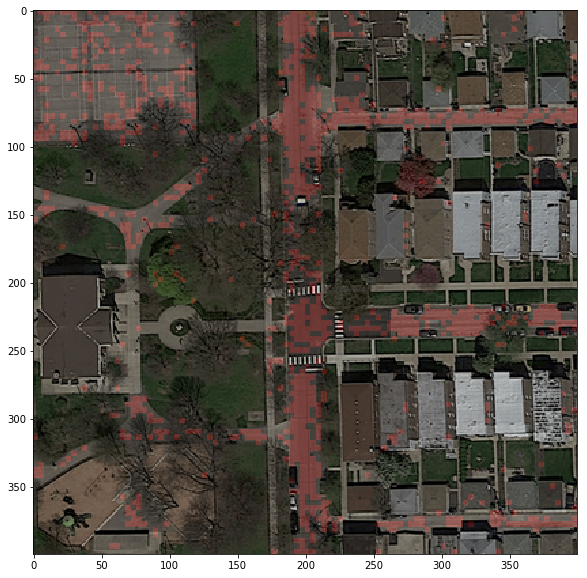

In [57]:

# we create an instance of the classifier and fit the data
img_idx=14

n_patch_per_img_train=int(((imgs[0].shape)[0]/patch_size)*((imgs[0].shape)[1]/patch_size))
print("number of patches for image")
print(n_patch_per_img_train)
i=img_idx*n_patch_per_img_train;
im=imgs[img_idx]
rows=range(i,(i+int(n_patch_per_img_train)))
w=400;
h=400;

Zi=neigh.predict(X_train_1[rows,:])



predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')
new_img = make_img_overlay(imgs[img_idx], predicted_im)
plt.imshow(new_img)






# For Test Set

23104


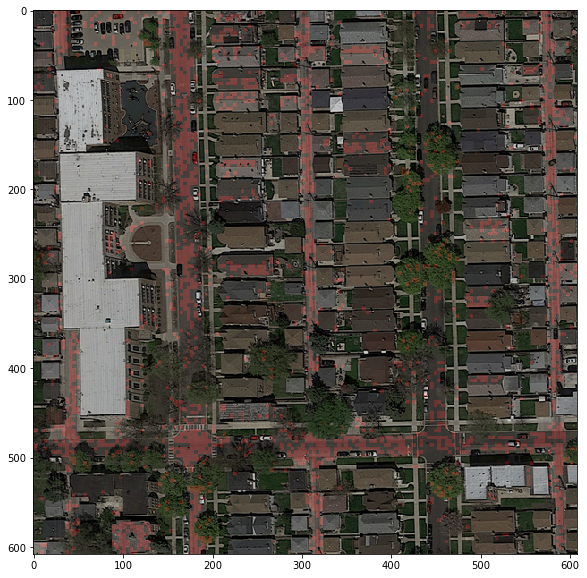

In [58]:
# we create an instance of the classifier and fit the data
img_idx=35;
n_patch_per_img_test=int(((imgs_test[0].shape)[0]/patch_size)*((imgs_test[0].shape)[1]/patch_size))
print(n_patch_per_img_test)


i=(img_idx)*n_patch_per_img_test;
im=imgs_test[img_idx]
rows=range(i,(i+int(n_patch_per_img_test)))
w=608;
h=608;


Zi=neigh.predict(X_test_1[rows,:])


predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs_test[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')
new_img = make_img_overlay(imgs_test[img_idx], predicted_im)
plt.imshow(new_img)




# Create the prediction

In [59]:
ind=1;
w = imgs_test[0].shape[0]
h = imgs_test[0].shape[1]
n_patch_per_img=int((w/patch_size)*(h/patch_size));


for i in range(0,len(X_test),n_patch_per_img):
    
    rows=range(i,i+n_patch_per_img)
    Xi=X_test_1[rows,:]
    
    Zi = neigh.predict(Xi);
    
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi);
    
    predicted_im =binary_to_uint8(predicted_im )
    Image.fromarray(predicted_im).save('image_predicted/prediction_' + '%.3d' % ind + '.png')
    ind=ind+1;

23104


# Correct the images

In [65]:
from fill_the_gaps_1 import *
fill_the_gaps('image_predicted/',4,4)

Loading 50 images
image_predicted/prediction_001.png
image_predicted/prediction_002.png
image_predicted/prediction_003.png
image_predicted/prediction_004.png
image_predicted/prediction_005.png
image_predicted/prediction_006.png
image_predicted/prediction_007.png
image_predicted/prediction_008.png
image_predicted/prediction_009.png
image_predicted/prediction_010.png
image_predicted/prediction_011.png
image_predicted/prediction_012.png
image_predicted/prediction_013.png
image_predicted/prediction_014.png
image_predicted/prediction_015.png
image_predicted/prediction_016.png
image_predicted/prediction_017.png
image_predicted/prediction_018.png
image_predicted/prediction_019.png
image_predicted/prediction_020.png
image_predicted/prediction_021.png
image_predicted/prediction_022.png
image_predicted/prediction_023.png
image_predicted/prediction_024.png
image_predicted/prediction_025.png
image_predicted/prediction_026.png
image_predicted/prediction_027.png
image_predicted/prediction_028.png
im

# Create the submission

In [66]:
from mask_to_submission import *
import glob


image_filenames=glob.glob('*.png')
print(image_filenames)
submission_filename='sample_submission.csv'
masks_to_submission(submission_filename, *image_filenames)

['prediction_corrected001.png', 'prediction_corrected002.png', 'prediction_corrected003.png', 'prediction_corrected004.png', 'prediction_corrected005.png', 'prediction_corrected006.png', 'prediction_corrected007.png', 'prediction_corrected008.png', 'prediction_corrected009.png', 'prediction_corrected010.png', 'prediction_corrected011.png', 'prediction_corrected012.png', 'prediction_corrected013.png', 'prediction_corrected014.png', 'prediction_corrected015.png', 'prediction_corrected016.png', 'prediction_corrected017.png', 'prediction_corrected018.png', 'prediction_corrected019.png', 'prediction_corrected020.png', 'prediction_corrected021.png', 'prediction_corrected022.png', 'prediction_corrected023.png', 'prediction_corrected024.png', 'prediction_corrected025.png', 'prediction_corrected026.png', 'prediction_corrected027.png', 'prediction_corrected028.png', 'prediction_corrected029.png', 'prediction_corrected030.png', 'prediction_corrected031.png', 'prediction_corrected032.png', 'predic